In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pandas as pd
import numpy as np

## Prepare target

In [18]:
from scipy import stats
def castToCategorical(x, n_category):
    mean = np.mean(x)
    std = np.std(x)
    site_points = stats.norm.ppf(np.arange(0,n_category) * 0.5 / n_category, loc=mean, scale=std)
    divide_points = np.concatenate([site_points,-site_points[::-1]])
    return pd.cut(x, bins=divide_points, labels=np.arange(-n_category+1,n_category))
    

In [19]:
N_CATEGORY = 3 
target = pd.read_csv("../database/mergedData/Quarterly_AVG_RET.csv", index_col=[0])
target["AVG_7D"]  = castToCategorical(target["AVG_7D"], N_CATEGORY)
target["AVG_14D"] = castToCategorical(target["AVG_14D"], N_CATEGORY)
target["AVG_21D"] = castToCategorical(target["AVG_21D"], N_CATEGORY)

## Prepare data

In [20]:
def castToDiffQuasiLog(report_value : pd.DataFrame) -> pd.DataFrame: 
    QUASI_LOG_VALUE = 1e-6
    new_index = report_value.index.to_numpy()[1:] # Without first row
    reports_np =  report_value.to_numpy()
    log_value = np.vectorize(lambda x : np.log10(np.max([x, QUASI_LOG_VALUE])))(reports_np[:,2:])
    log_diff = log_value[1:] - log_value[:-1]
    reports_np = reports_np[1:]
    reports_np[:, 2:] = log_diff
    return pd.DataFrame(data=reports_np, 
                        columns=report_value.columns, 
                        index=new_index)

def castDatabaseToQuasiLog(database):
    #Prepare data frame 
    log_diff_database = pd.DataFrame(columns=database.columns)

    # For all tickers 
    tickers = database["Ticker"].unique()
    for ticker in tickers:
        company_data = database[database["Ticker"] == ticker]
        company_log_diff = castToDiffQuasiLog(company_data)
        log_diff_database = pd.concat([log_diff_database, company_log_diff], ignore_index=False)

    return log_diff_database

In [21]:
data = pd.read_csv(../database/mergedData/Quarterly_V.csv)
data = castDatabaseToQuasiLog(data)
data = data.drop(columns = ["Ticker", "Data"])

### Collinear data 

In [22]:
balance_first_stage = [
    "Aktywa razem", 
    "Pasywa razem",
    ]

balance_second_stage = [
    "Aktywa trwałe",
    "Aktywa obrotowe",
    "Kapitał własny akcjonariuszy jednostki dominującej",
    "Udziały niekontrolujące",
    "Zobowiązania długoterminowe",
    "Zobowiązania krótkoterminowe",
]

balance_third_stage = [
    "Wartości niematerialne i prawne",
    "Rzeczowe składniki majątku trwałego",
    "Należności długoterminowe",
    "Inwestycje długoterminowe",
    "Pozostałe aktywa trwałe",
    "Zapasy",
    "Należności krótkoterminowe",
    "Inwestycje krótkoterminowe",
    "Środki pieniężne i inne aktywa pieniężne",  # four stage
    "Pozostałe aktywa obrotowe",
    "Aktywa trwałe przeznaczone do sprzedaży",
    "Kapitał (fundusz) podstawowy",
    "Udziały (akcje) własne",
    "Kapitał (fundusz) zapasowy",
    "Z tytułu dostaw i usług",
    "Kredyty i pożyczki",
    "Z tytułu emisji dłużnych papierów wartościowych",
    "Zobowiązania z tytułu leasingu finansowego",
    "Inne zobowiązania długoterminowe",
    "Z tytułu dostaw i usług",
    "Kredyty i pożyczki",
    "Z tytułu emisji dłużnych papierów wartościowych",
    "Zobowiązania z tytułu leasingu finansowego",
    "Inne zobowiązania krótkoterminowe",
    "Rozliczenia międzyokresowe",
]

# Remove 
data = data.drop(columns=balance_first_stage + balance_third_stage)

### Correlation

<Figure size 2000x1000 with 0 Axes>

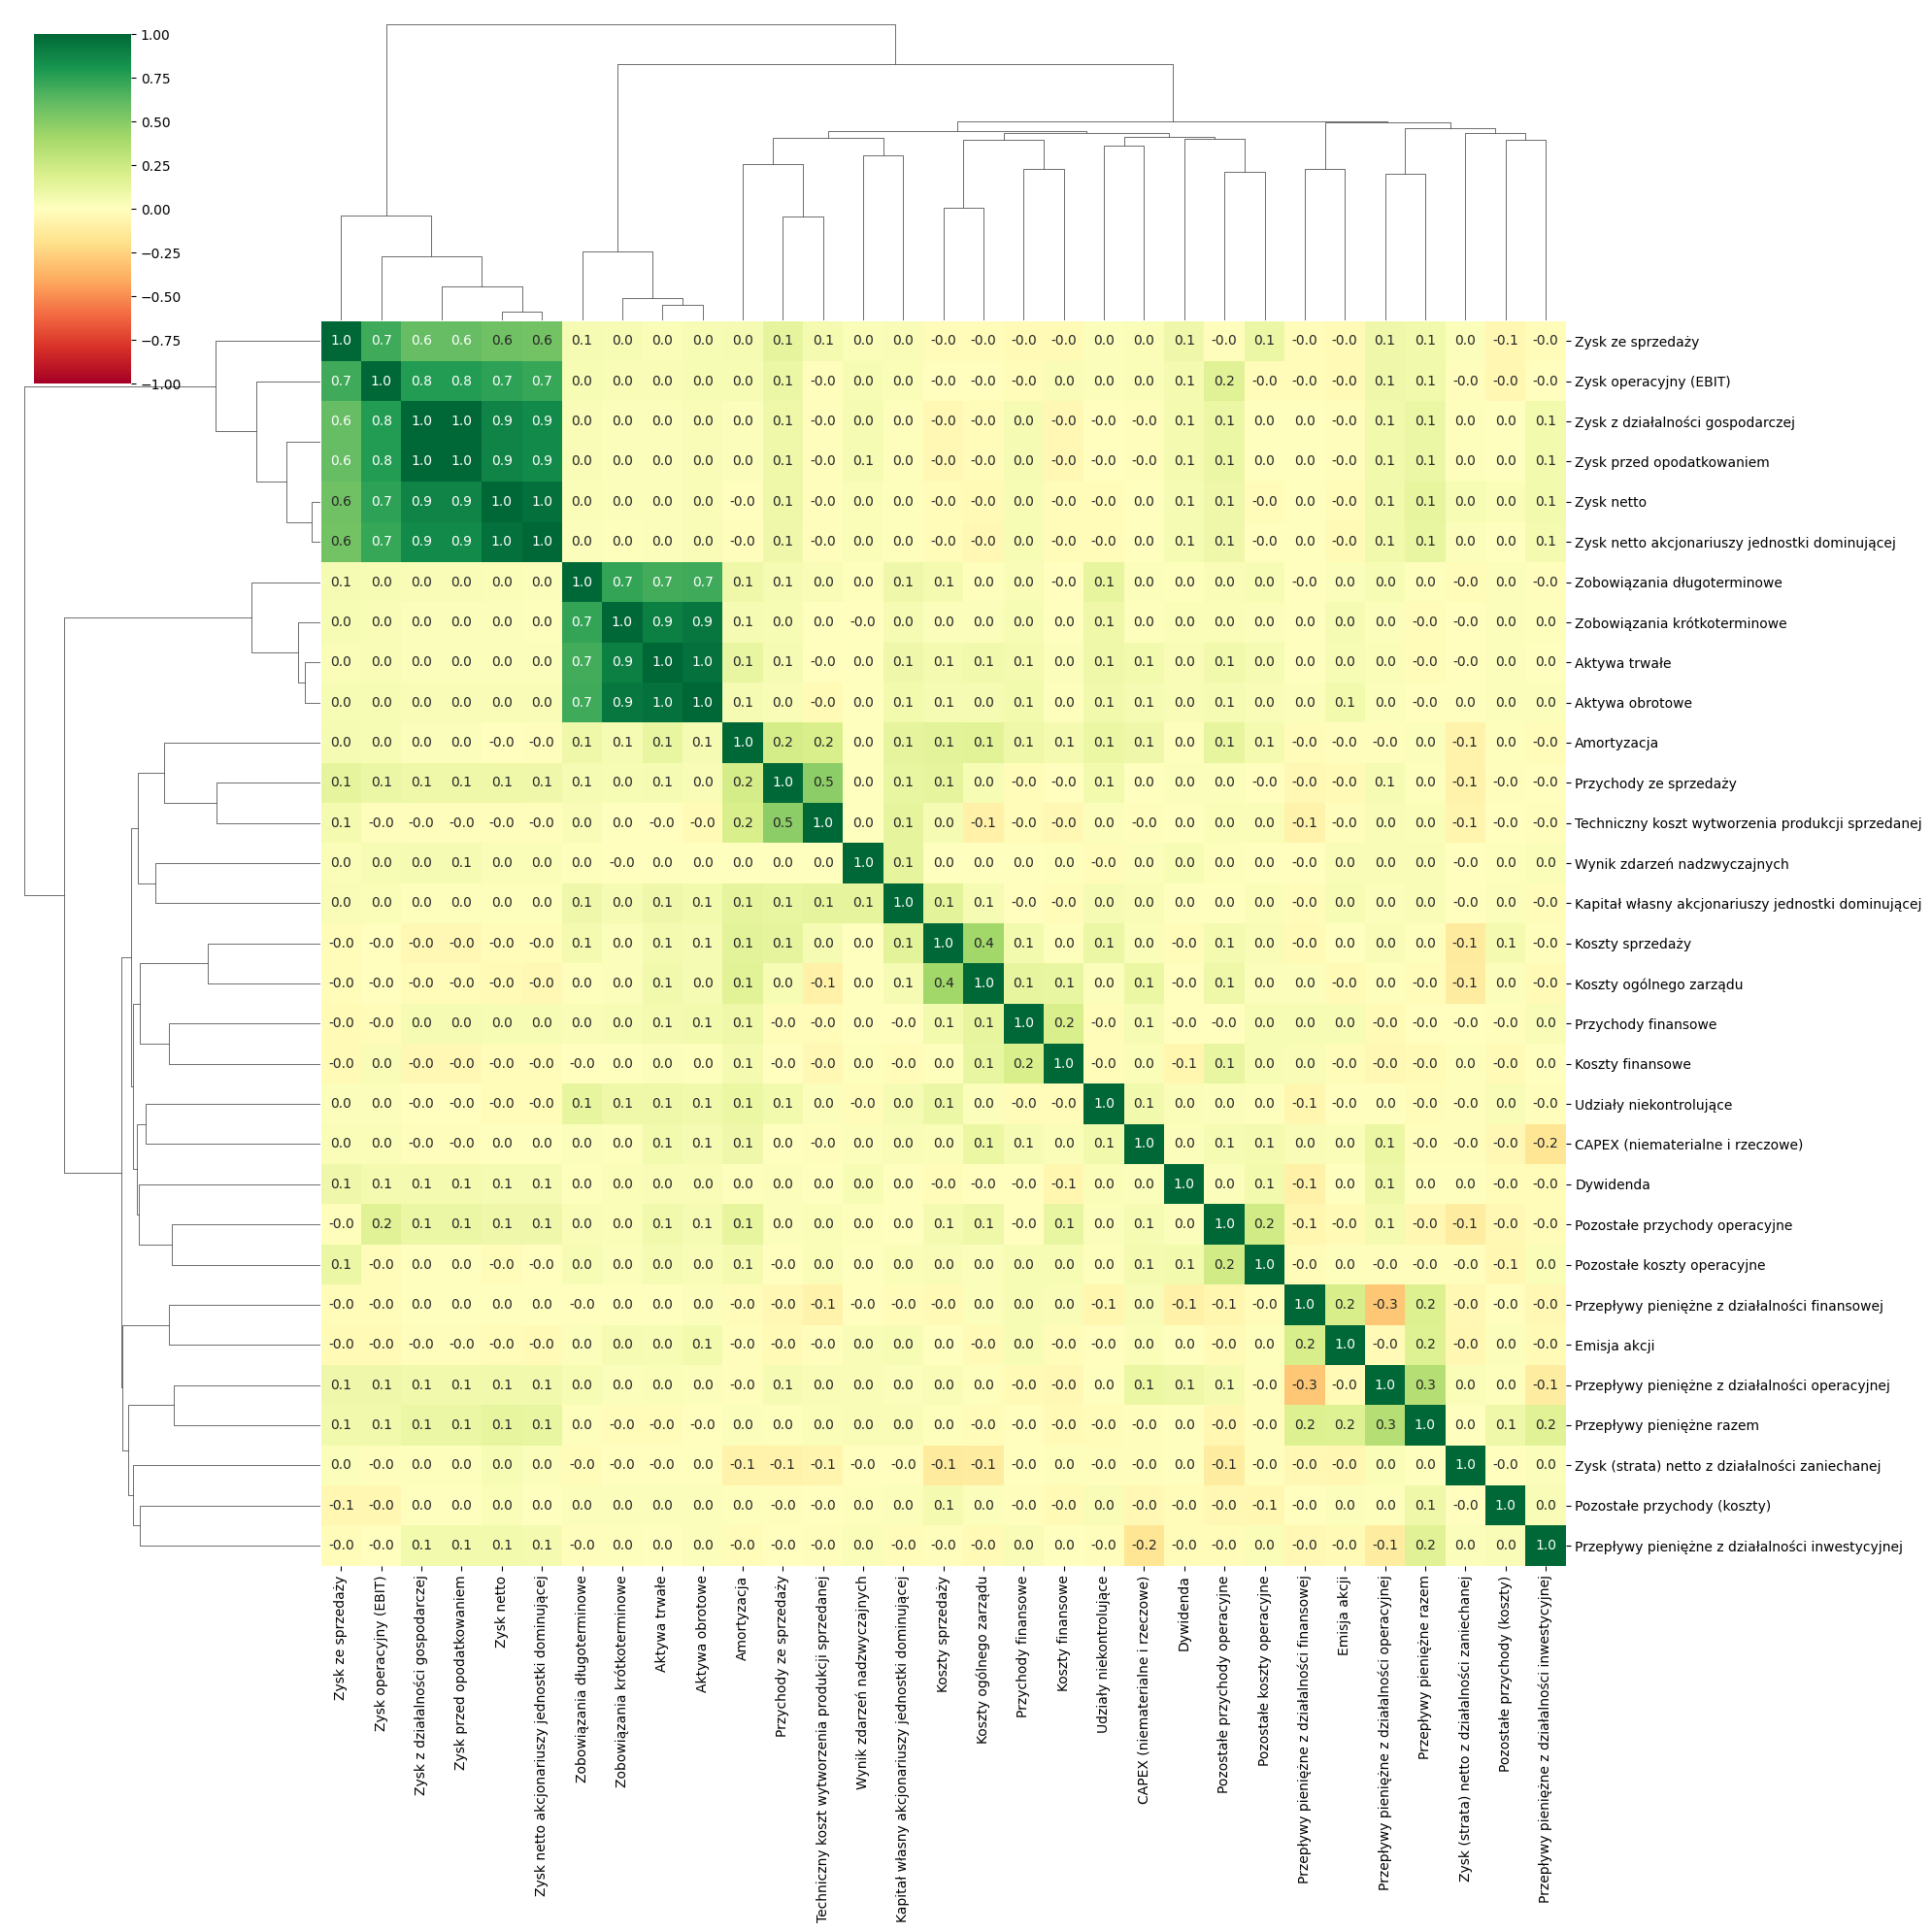

In [23]:
cmap = LinearSegmentedColormap.from_list('', ['blue', 'white', 'blue'])
plt.figure(figsize=(20,10))
sns.clustermap(data.corr(), cmap='RdYlGn', vmin=-1, vmax=1, fmt='.1f', annot=True, figsize=(20, 20))
plt.show()

In [24]:
correlated_data =[         # Data correlated to 'Zysk netto',
    'Zysk z działalności gospodarczej',
    'Zysk przed opodatkowaniem',
    'Zysk netto akcjonariuszy jednostki dominującej',
    'Zysk ze sprzedaży',
    'Zysk operacyjny (EBIT)',
]

data = data.drop(columns=correlated_data)

## Concatenate data

In [25]:
database = pd.concat([data, target], axis=1, join="inner") 

## Learning

In [26]:
from sklearn.model_selection import train_test_split
TARGET = 'AVG_7D'
df_train, df_test = train_test_split(database,
                            train_size=2/3,
                            stratify=database[TARGET])

X_train = df_train.to_numpy()[:,:-3]
y_train = df_train[TARGET].to_numpy()

X_test = df_test.to_numpy()[:,:-3]
y_test = df_test[TARGET].to_numpy()

In [28]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

In [29]:
from sklearn.ensemble import RandomForestClassifier 

rf = RandomForestClassifier(n_estimators = 500,
                            max_depth = 5,
                            n_jobs = -1, 
                            class_weight='balanced')
rf.fit(X_resampled, y_resampled)


RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=500,
                       n_jobs=-1)

ACC = 0.35587108406581025


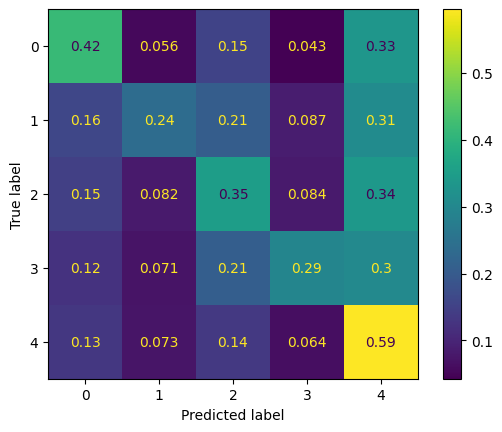

In [30]:
from sklearn import metrics 
y_pred = rf.predict(X_train)

# Jakość klasyfikacji
acc = metrics.accuracy_score(y_train, y_pred)

# Macierz pomyłek
cm = metrics.confusion_matrix(y_train, y_pred, labels=rf.classes_, normalize='true', )

print(f"ACC = {acc}")
disp = metrics.ConfusionMatrixDisplay(cm, )
disp.plot()
plt.show()

ACC = 0.22036953582694907


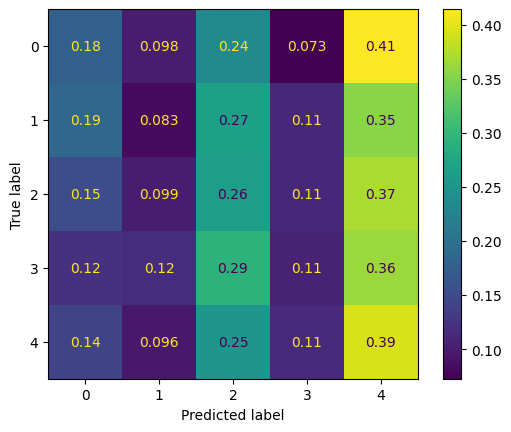

In [31]:
from sklearn import metrics 
y_pred = rf.predict(X_test)

# Jakość klasyfikacji
acc = metrics.accuracy_score(y_test, y_pred)

# Macierz pomyłek
cm = metrics.confusion_matrix(y_test, y_pred, labels=rf.classes_, normalize='true', )

print(f"ACC = {acc}")
disp = metrics.ConfusionMatrixDisplay(cm, )
disp.plot()
plt.show()

## Neural network

In [16]:
from sklearn.preprocessing import StandardScaler

std_transformer = StandardScaler().fit(X_resampled)
X_train_std = std_transformer.transform(X_resampled)
X_test_std = std_transformer.transform(X_test)

NameError: name 'X_resampled' is not defined

In [ ]:
y_resampled = StandardScaler().fit_transform(X_resampled)

In [ ]:
from keras.utils import to_categorical

categorical = to_categorical(y_resampled+2, num_classes=5)

IndexError: index 7 is out of bounds for axis 1 with size 5

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(26,)),  # Wymiary danych wejściowych: 26 cech
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(1)  # 5 wyjść dla 5 klas
])


In [ ]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])


In [ ]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 32)             │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,089 (19.88 KB)

 Trainable params: 5,089 (19.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for _ in range(100):
    history = model.fit(X_resampled, y_resampled, epochs=100, validation_split=0.2)

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.6046 - mse: 2.6046 - val_loss: 0.6779 - val_mse: 0.6779
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1159 - mse: 1.1159 - val_loss: 0.6760 - val_mse: 0.6760
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0679 - mse: 1.0679 - val_loss: 0.6699 - val_mse: 0.6699
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0550 - mse: 1.0550 - val_loss: 0.6649 - val_mse: 0.6649
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0203 - mse: 1.0203 - val_loss: 0.6594 - val_mse: 0.6594
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0429 - mse: 1.0429 - val_loss: 0.6566 - val_mse: 0.6566
Epoch 7/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0691 - mse: 1.0691 - val_loss: 0.6555 - val_mse: 0.6555
Epoch 8/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0349 - mse: 1.0349 - val_loss: 0.6532 - val_mse: 0.6532
Epoch 9/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

KeyboardInterrupt: 

In [ ]:
y_train_pred = model.predict(X_resampled) 
y_val_pred = model.predict(X_test_std) 

358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step


ACC = 0.1505182514646237


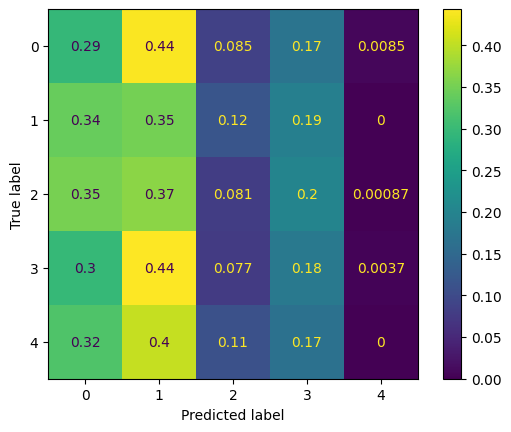

In [ ]:
from sklearn import metrics 

# Jakość klasyfikacji
acc = metrics.accuracy_score(y_test, np.argmax(y_val_pred, axis=1)-2)

# Macierz pomyłek
cm = metrics.confusion_matrix(y_test, np.argmax(y_val_pred, axis=1)-2, labels=rf.classes_, normalize='true', )

print(f"ACC = {acc}")
disp = metrics.ConfusionMatrixDisplay(cm, )
disp.plot()
plt.show()